# Lab 6 Part B: AX.25 and APRS
## Please read the text in this lab carefully, there's lots of important detailed information everywhere. 

In this part of the lab we are going to experiment with Digital modulation and communication. Network Communication systems have layered architechture. The bottom layer is the physical which implements the modulation. Here we will use your [AFSK](http://en.wikipedia.org/wiki/Frequency-shift_keying) modules that you implemented in Lab 6. In addition, we will leverage [AX.25](http://www.tapr.org/pub_ax25.html), which is an amateur-radio data-link layer protocol. [AX.25](http://www.tapr.org/pub_ax25.html) is a packet based protocol that will help us transmit data using packets. It implements basic synchronization, addressing, data encapsulation and some error detection.  In the ham world, an implementation of AFSK and [AX.25](http://www.tapr.org/pub_ax25.html)  together is also called a [TNC ( Terminal Node Controller )](http://en.wikipedia.org/wiki/Terminal_node_controller). In the past TNC's were separate boxes that hams used to attach to their radios to communicate with packet-based-communication. Today, it is easy to implement TNC's in software using the computer's soundcard.... as you will see here! 




In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
from __future__ import division

import threading,time
import multiprocessing

from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


For the following tasks you will need the functions:

`sg_plot`  included in lab7.py

`myspectrogram_hann_ovlp` included in lab7.py

`play_audio` included in lab7.py

`record_audio`  included in lab7.py

`printDevNumbers`  included in lab7.py

`text2Morse` (to Identify yourself before transmission)

`afsk1200` (from the previous lab)

`nc_afskDemod` (from the previous lab)

In [2]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        


Copy and paste your afsk1200 and nc_afskDemod functions here:

In [3]:
# copy and paste your own functions here. 

def afsk1200(bits):
    #the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    fs = 44100*4
    baud = 1200
    fc = 1700
    delf = 500
    
    bits = np.array(bits.tolist())
    
    #print bits < 1
    
    bits = bits.astype(int)
    
    np.place(bits, bits < 1, [-1])
    
    #print bits
    
    #width, height = figaspect(0.2)
    #fig = figure(figsize=(width,height))

    #plot(np.r_[0:bits.size], bits)

    #your code here
    sperb = fs/baud
    
    t = np.r_[0:bits.size*sperb]
    integ = integrate.cumtrapz(np.repeat(bits, sperb), initial=0)
    
    #fig = figure(figsize=(width,height))
    #plot(np.r_[0:integ.size], integ)
    
    ph = t*2*pi*fc/fs + integ*2*pi*delf/fs
    
    sig = real(exp(1j*ph[::4]))
    
    return sig
        
              


def nc_afskDemod(sig, TBW=2.0, N=74):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZI (without rectifying it)
    
    # your code here
    
    # Generate filters
    
    fs = 44100
    TBW = 2
    N = 147
    BW = 1200/fs
    lowpass = signal.firwin(N, BW)
    t = np.r_[0:N]
    h_space = exp(1j*t*2*pi*2200/fs)*lowpass
    h_mark = exp(1j*t*2*pi*1200/fs)*lowpass
    
    sig_space = signal.fftconvolve(sig, h_space)
    sig_mark = signal.fftconvolve(sig, h_mark)
    
    #NRZI = np.absolute(sig_mark) - np.absolute(sig_space)
    
    #return NRZI > -0.02
   
    mark = np.absolute(sig_mark)
    space = np.absolute(sig_space)

    NRZI = (mark-space)
    return NRZI



Now, similarly to before, find the audio interface numbers. And intitialize the variables:
dusb_in, dusb_out, din, dout 



In [38]:
        
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Microsoft Sound Mapper - Input
1 Microphone (USB PnP Sound Devic
2 Microphone (VIA High Definition
3 Stereo Mix (VIA High Definition
4 Microsoft Sound Mapper - Output
5 Speakers (USB PnP Sound Device)
6 Speakers (VIA High Definition A
7 SPDIF Interface (TX0) (VIA High
8 Primary Sound Capture Driver
9 Microphone (USB PnP Sound Device)
10 Microphone (VIA High Definition Audio)
11 Stereo Mix (VIA High Definition Audio)
12 Primary Sound Driver
13 Speakers (USB PnP Sound Device)
14 SPDIF Interface (TX0) (VIA High Definition Audio)
15 Speakers (VIA High Definition Audio)
16 SPDIF Interface (TX0) (VIA High Definition Audio)
17 Speakers (VIA High Definition Audio)
18 Speakers (USB PnP Sound Device)
19 Microphone (VIA High Definition Audio)
20 Microphone (USB PnP Sound Device)
21 Stereo Mix (VIA High Definition Audio)
22 SPDIF Out (HD Audio digital out)
23 Speakers (VIA HD Audio Output)
24 Microphone (VIA HD Audio Microphone)
25 Stereo Mix (VIA HD Audio Stereo Mixer)
26 Speakers (USB PnP Soun

In [5]:
# CHANGE!!!!
dusb_in = 1
dusb_out = 5
din = 2
dout = 7

Initialize serial port

In [40]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='COM7') # CHANGE !!!!!!

## AX.25 (from: http://n1vg.net/packet/ and http://www.tapr.org/pub_ax25.html)

Before we go to demodulate AFSK1200 we will construct data in the form of AX.25 packets. The structure of the AX.25 packet, and in particular the flag that starts and ends a frame will help us sync to the beginning of the packet for accurate demodulation. 
The AX.25 protocol uses several measures for standartization and to improve detection and demodulation of packets. We will go over them now:

#### NRZI (non-return to zero inverted)
AX.25 does not encode  NRZ '1's and '0's in the usual mark and space frequencies. Instead it uses a scheme called NRZI, or non-return to zero inverted.  NRZI encodes a '0' bit as a change from mark to space, or space to mark. A '1' is encoded as no change.  To encode an AX.25 packet we need to convert our bit sequence to an NRZI one.  For example, an original bit stream of 11011000 should be first converted to 11000101 (initial state is 1). 

#### Bit Stuffing
Because a '1' is represented by no change, sending a long string of '1's would result in a constant signal. This may result in a receiver drifting out of sync with the transmitter. In order to circumvent this, the encoder performs bit stuffing before transmition by placing   a bit '0' after every fifth '1' in the the stream. The decoder does bit unstuffing and removes the extra '0's. Bit stuffing is performed before converting to NRZI.

#### Bit Order
Bytes are sent least-significant-bit first

#### Flag
A Flag field starts and ends each packet. It is a unique sequence and is used to detect the beginning and the end of packets. The flag consists of the bit sequence: 0x7E or: 01111110. The flag is an exception in which no bit stuffing is performed. Therefore it is the only place in the packet in which 6 consequitive '1's appear. In NRZI it will translate to a time interval of 7 bits between zero-corssing of the non-coerent detector output.  This means that we can use the flag sequence to uniquly detect a packet. 

#### Frame Structure
The Ax.25 protocol defines several type of frames. We will use the Un-numbered Information (UI) frame as defined in the protocol. UI frame is used for connectionless mode, where AX.25 frmaes are transmitted without expecting any response, and reception is not guaranteed. 
The UI frame that is used in the [Automatic Positioning and Reporting System (APRS)](http://en.wikipedia.org/wiki/Automatic_Packet_Reporting_System) protocol and has 9 fields of data:

| flag | Dest. Addr. | Src. Addr. |Digipeter Addresses | Control field | ID | Information Field | FCS | Flag |
|----:|-----------:|----------:|:------------------:|:-------------:|:--:|:-----------------:|:---:|:----:|
|1     |     7       |     7      |    56              |       1       |  1 |     256           |  2  |  1   |

Of importance are the Source address, which are your call sign, the Information Field which is the packet payload, the FCS which is a error checksum.

#### FCS Field
The FCS field is always the last two bytes in the packet. They are a checksum that can be used to determine the integrity of the packet. 

## APRS (information from: [Here](http://www.aprs.org/doc/APRS101.PDF) and [here](http://www.aprs.org/iss-aprs/issicons.html))
APRS is a ham packet-based system for real-time tactical digital communication for local area. APRS uses the AX.25 protocol in its core. Using APRS you can report position, status, and send messages that other hams or stations with APRS capability will able to decode, interpret and display the information. APRS also provides means of packet repeating (Digipeters) alongside with internet terminal nodes. Some radio manufacturers saw the potential and included APRS in some of their products as well. Go to this website: https://aprs.fi  to see the APRS activity in the surrounding area that is aggregated from the internet nodes. You will see fixed stations, weather stations as well as mobile operators in your area. We will use the website to confirm that our transmitted packets were received. 

### Frequencies:
The national APRS frequency is 144.39MHz (ch-117 on your radio). There is much activity and infrastracture transmitting and listenning to that frequency. The international space station also has an APRS digipeter on board operating at 145.825MHZ (ch-50 on your radio). You can also use AX.25 on any of the digital or experimental channels in the bandplan -- though you will have to coordinate if you want anybody to hear you! 

### APRS Destination, source, digipeter address, control, ID and FCS packet fields
For APRS packets, the Destination address field is not used for routing. Instead it represents the version of the APRS software you are using. In order to be decoded by receivers in the APRS network it must start with the letters AP. We will use APDSP just for fun. 
The source address is your call sign. The digipeter addresses require some explenation but the fields 'WIDE1-1,WIDE2-1' will result in the packet being digipeted a maximum of 2 hops. In dense population areas like the bay area 'WIDE1-1' is often enough to get your packet to its destination. The Control and ID fields are fixed to "\x03" and "\xF0" respectively. The FCS field is the checksum field as defined by AX.25. The flag fields are the usual 01111110.

We have prepared for you code that generates valid bitstream of AX.25 packets from the appropriate fields as well as decode the fields from a bitstream. The code is a modification of code oroginally written by: Greg Albrecht W2GMD. You will have to download the code from the class website


 
### The APRS informatrion field
The information field of the packet are 256 Bytes payload that contain the information you want to send. We will go over some of the information that is needed to construct valid and useful information field messeges. There are several digipeters in the bay area that have internet terminal nodes. These implement several "fun" and useful services. For example, you can send a position report that would show up on a google map. You can also send a short EMAIL by sending an APRS packet. 

How a node or a client interprets your packet depends on the information field structure. There are three types of packets: Position, Status and Messages
#### Messages

Just begin your packet line with a Colon and a 9 character TOASDDRESS, another colon and then text. 
The TOADDRESS must have 9 characters and should be filled with spaces if it is smaller. 

Examples of messages:

* :ALL------:Everyone will capture this 64 byte message text.
* :KK6MRI---:This message will only show on Miki's APRS enabled Yaezu VX-8dr radio screen
* :EMAIL----:mlustig@eecs.berkeley.edu I sent you an email Miki through an OpenAPRS node!

The "-----" are blank spaces to fill the space to 9 characters.  

#### Position
You can report your position to people on the APRS system. If your report is picked up by a node it will show up on http://www.aprs.fi. The basic format of a position packet is:

| ! or = symbols | Lattitude 8 chars | / | Longitude 9 chars| icon 1 char| Comment max 43 chars |
|---------------|-------------------|---|------------------|------------|----------------------|
| =             | 3752.50N|        /| 12215.43W|            K|Shows a school symbol on Cory Hall position|
| =             |3752.45N |/|12215.98W|[|Shows a person walking on Oxford and Hearst|
| =             |2759.16N |/|08655.30E|[|I'm on the top of the world! (Mt. Everest)|

The latitude format is expressed as a fixed 8-character field, in degrees and decimal minutes (to two decimal places), followed by a letter N for north and S for south. Latitude minutes are expressed as whole minutes and hundredths of a minute, separated by a decimal point. Longitude is expressed as a fixed 9-character field, in degrees and decimal minutes (to two decimal places), followed by the letter E for east or W for west. Longitude degrees are in the range 000 to 180. Longitude minutes are expressed as whole minutes and hundredths of a minute, separated by a decimal point.

In generic format:

* Latitude is expressed as: ddmm.hhN (i.e. degrees, minutes and hundredths of a minute north)
* Longitude is expressed as: dddmm.hhW (i.e. degrees, minutes and hundredths of a minute west)

For example Cory Hall is at N37° 52.5022', W122° 15.4395'. So the position is encoded as:
3752.50N/12215.43W

You can go to http://www.gpsvisualizer.com/geocode to find the coordinates of an address. Note: use the degree, minutes representation, not the decimal one. 

a 1 character icon is provided after the coordinates. This will show an icon on the http://aprs.fi maps. Here are some useful ones:

* \- House with a VHF vertical
*  < Motorcycle
* \> Car
* Y Sailboat
* b Bike
* [ Jogger, walker, runner
* X Helo
* K School

Examples:

a school symbol 
* =3752.50N/12215.43WKShows a school symbol on Cory Hall position.
* =3752.45N/12215.98W[Shows a person walking on Oxford and Hearst
* =3752.❏❏N/12215.❏❏-Shows a house symbol somewhere in Berkeley.

#### Status
A status packet starts with '>' character. It wil show on APRS equipped radios. 

Examples:

*  \>I like radios
*  \>Monitoring 146.430MHz PL 66
*  \>On My way home



## Your first APRS packet
In the following section we will construct a valid (bitstuffed) bitstream from the different APRS packet fields. We will convert to an NRZI representation and modulate to generate a valid AFSK1200 APRS Packet. We will transmit it over the radio and look at http://aprs.fi to see if it was received by a node. 

### Bitstream from APRS fields

The following code shows you how to construct a message packet that will tell a digipeter to send you an email. Make sure you fill the correct information in the fields. The bitstream will already be bitsuffed with zeroes. 


In [4]:
import ax25

callsign = "KK6STA"
Digi =b'WIDE1-1,WIDE2-1'
dest = "APDSP"

# Uncomment to Send Email
#info = ":EMAIL    :openg@berkeley.edu What a great lab!"

# Uncomment to Send an SMS message to a phone number (update the number!)
info = ":SMSGTE   :@4087687685 This is a text message from my radio"

#uncomment to show yourself on mt everest
#info = "=2759.16N/08655.30E[I'm on the top of the world"

#uncomment to send to everyone on the APRS system near you
#info = ":ALL      : CQCQCQ I would like to talk to you!"


# uncomment to report position
#info = "=3752.50N/12215.43WlIm using a laptop in Cory Hall!"

# uncomment to send a status message
#info = ">I like radios"


packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet.unparse())

bitarray('011111100100000100000101000100010110010100000101000000100000011001101001011010010011011001100101000101010100000100000110011101010100100100010001010100010100011000000010010001100111010101001001000100010101000100100110000000101100011011000000000011110101110011001010101100101100101011100010001010101010001000000100000001000000010001011100000000100010110000001100000111001110110001101100000111001110110001101100000111001010110000000100001010100001011010010110110011100000010010010110110011100000010010000110000001000010111010100110000111100010111000000100101101101010011011001110110011101000011011100110101001100000010001100110010011101111011010110110000001001011011010011110000001000100111010000110001001101001011011110110101100101101110101111110')


### Converting a stream of bits to NRZI (zeros represent by change of 0-1 or 1-0 and ones are no change)
Recall that AX.25 packets are sent with NRZI encoding in which a '0' is a change and a '1' is no change. 

* The following function `NRZI = NRZ2NRZI(bits)`,  takes a standard bitarray stream and converts it to a bitarray stream representing '0's as change and '1's as unchanged. For example, an input of 0000111100 will result in 0101111101. This assume an initial state of '1'. 


In [5]:
def NRZ2NRZI(NRZ):
    NRZI = NRZ.copy() 
    current = True
    for n in range(0,len(NRZ)):
        if NRZ[n] :
            NRZI[n] = current
        else:
            NRZI[n] = not(current)
        current = NRZI[n]
    return NRZI


### Constructing and Transmitting an APRS AX.25 Packet. 


* Construct an AFSK1200 signal out of the APRS packet. 
* Play the audio on your computer speaker. It will sound like an old modem (which is what it is!)
* Plot its spectrogram. You should be able to see the bits. 
* It is recommended to **add a stream of 160 zero-bits before the message**. This will translate into alternating between Mark and Space and help any receiver to lock on the bit rate and sync to the package


In [14]:
def play_audio_direct( data, p, fs):
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs,output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )

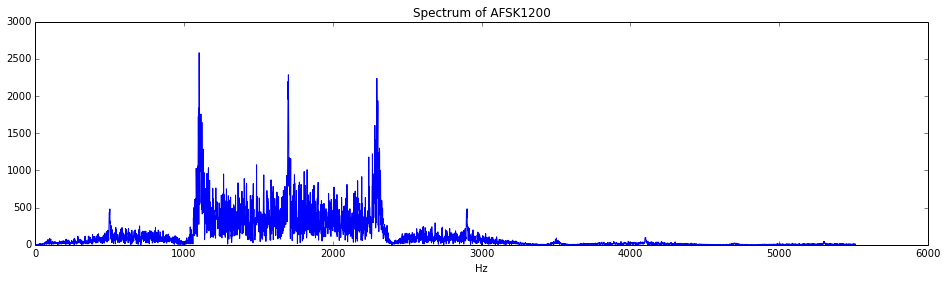

In [30]:
# construct message
msg = afsk1200(NRZ2NRZI(bitarray.bitarray(zeros(160).tolist())+packet.unparse()))



# display spectrogram
fig = figure(figsize(16,4))
plot(linspace(0,22050/4,20000/4),abs(np.fft.fft(msg,n=40000))[:20000/4])

xlabel('Hz')
title('Spectrum of AFSK1200')


# play message on your speaker
# instantiate PyAudio
p = pyaudio.PyAudio()
# play sound
play_audio_direct( msg, p, 44100 )

# terminate pyAudio
p.terminate()


* Tune your radio to the APRS national frequency: 144.39MHz or Channel 117 on your radio. 
* Send the APRS packet through your radio. As always it is better to be outside in a high place. If you are near Cory Hall you should be OK, we have an APRS internet gateway in Cory.
* Sometimes it is useful to send the packet twice, just to make sure it goes through. 
* Be very carefull that your radio is operating appropriately, i.e., not getting stuck in transmit etc. We do not wish to interfere with the APRS network!



In [43]:
p = pyaudio.PyAudio()

Qout = Queue.Queue()


Qout.put("KEYON")
Qout.put(msg/1.5)
Qout.put("KEYOFF")
Qout.put("EOT")

play_audio(Qout,   p, 44100, dusb_out, s,0.3)


time.sleep(1)
p.terminate()


* Did you get an email? SMS? If so, try sending a position report and check in https://aprs.fi. You can also search for your callsign, and then press the raw-packets link. It will show you all the packets received from you in the last 48 hours.

## Decodeing AX.25 and APRS Packets

Now that we know how to create AX.25 and APRS packets, know how to AFSK1200 modulate them, know how to demodulate AFSK1200 as well, we can move forward to receiving and decoding packets. By the end of that we will have a fully functioning communication system.

Download the file [ISSpkt.wav](https://inst.eecs.berkeley.edu/~ee123/sp14/lab3/ISSpkt.wav). It contains an APRS packet I recorded on one of the ISS flybyes. Load it to your workspace using the function `wavread`, which we imported from `scipy.io`.
(ISSpkt.wav) 


In [45]:
sig = wavread("ISSpkt.wav")[1]


We will now automate the packet decoding by writing some functions that implement portions of the process.

* Run the function `nc_afskDemod` on the ISS to get the demodulated "analog" NRZI
* Plot the signal. It should look like a signal with $\pm1$ switching!
* compute the signum to get the rectified digital NRZI.

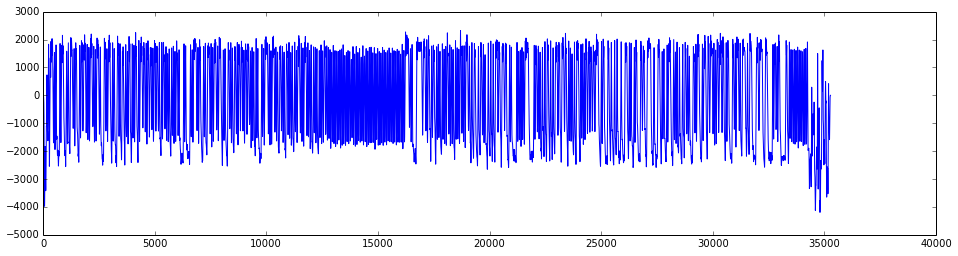

In [46]:
NRZIa = nc_afskDemod(sig)
fig = figure(figsize(16,4))
plot(NRZIa)
NRZI = sign(NRZIa)

### Decoding Bits from the Demodulated NRZI Signal
We know how to get the NRZI signal, but the main issue that is left to resolve is to detect when a packet is received and synchronize to the beginning of it so we can correctly interpret its bits. 

There are many ways to do this. Here we will use a simple decoder that is based on zero-crossings of the NRZI sequence. Recall that a '1' is encoded by no change and a '0' is encoded by change of sign. Therefore, if we see a 1 bit time-length between zero crossing we can decode that transition as a '0'. If we see 2 bit time-length between zero crossings of the NRZI we can decode this as '10'. Similarly if we see a 3 bit time-length we decode it all as '110', 4 as '1110', 5 as '11110' and 6 as '111110'. 
Because of the bit-stuffing, the only 7 bit time-length valid sequence is the flag sequence that marks the begining and the end of the packet. Of course we can not expect the transitions to be accurate due to noise and other corruptions. We therefore give an error margin of 1/2 a bit-length for decoding.  For example, we will decode a '0' for zero-crossing interval between 1/2 a bit and 3/2 bits., a '10' for zero-crossing interval between 3/2 and 5/2 bits, etc. 

We have implemented the decoding as a state machine for you. We first look for a flag sequence. When it is found we start collecting the bits of the packet. If at any time we get an invalid interval length we discard the data and start looking again for a flag. If the second flag is detected, a packet is announced. We then check if the checksum is valid. If it is, the packet is recorded and returned. 




In [6]:
# function to generate a checksum for validating packets
def genfcs(bits):
    # Generates a checksum from packet bits
    fcs = ax25.FCS()
    for bit in bits:
        fcs.update_bit(bit)
    
    digest = bitarray.bitarray(endian="little")
    digest.frombytes(fcs.digest())

    return digest


# function to parse packet bits to information
def decodeAX25(bits):
    ax = ax25.AX25()
    ax.info = "bad packet"
    
    
    bitsu = ax25.bit_unstuff(bits[8:-8])
    
    if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
        #print("failed fcs")
        return ax
    
    bytes = bitsu.tobytes()
    ax.destination = ax.callsign_decode(bitsu[:56])
    source = ax.callsign_decode(bitsu[56:112])
    if source[-1].isdigit() and source[-1]!="0":
        ax.source = b"".join((source[:-1],'-',source[-1]))
    else:
        ax.source = source[:-1]
    
    digilen=0    
    
    if bytes[14]=='\x03' and bytes[15]=='\xf0':
        digilen = 0
    else:
        for n in range(14,len(bytes)-1):
            if ord(bytes[n]) & 1:
                digilen = (n-14)+1
                break

#    if digilen > 56:
#        return ax
    ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8])
    ax.info = bitsu[112+digilen*8+16:-16].tobytes()
    
    return ax


def detectFrames(NRZI):  
    # function looks for packets in an NRZI sequence and validates their checksum
    
    # compute finite differences of the digital NRZI to detect zero-crossings
    dNRZI = NRZI[1:] - NRZI[:-1]
    # find the position of the non-zero components. These are the indexes of the zero-crossings. 
    transit = nonzero(dNRZI)[0]
    # Transition time is the difference between zero-crossings
    transTime = transit[1:]-transit[:-1]
    
    # loop over transitions, convert to bit streams and extract packets
    dict = { 1:bitarray.bitarray([0]), 2:bitarray.bitarray([1,0]), 3:bitarray.bitarray([1,1,0]),
            4:bitarray.bitarray([1,1,1,0]),5:bitarray.bitarray([1,1,1,1,0]),6:bitarray.bitarray([1,1,1,1,1,0])
            ,7:bitarray.bitarray([1,1,1,1,1,1,0])}
    
    state = 0; # no flag detected yet
    
    packets =[]
    tmppkt = bitarray.bitarray([0])
    lastFlag = 0  # position of the last flag found. 
    
    for n in range(0,len(transTime)):
        Nb = round(transTime[n]/36.75)  # maps intervals to bits. Assume 44100Hz and 1200baud
        if (Nb == 7 and state ==0):
            # detected flag frame, start collecting a packet
            tmppkt = tmppkt +  dict[7]
            state = 1  # packet detected
            lastFlag = transit[n-1]
            continue
        if (Nb == 7 and state == 1):
            # detected end frame successfully
            tmppkt = tmppkt + dict[7]
            
            # validate checksum
            bitsu = ax25.bit_unstuff(tmppkt[8:-8]) # unstuff bits
            if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) :
                # valid packet
                packets.append(tmppkt)                
            tmppkt  = bitarray.bitarray([0])
            state = 0
            continue
        
        if (state == 1 and Nb < 7 and Nb > 0):
            # valid bits 
            tmppkt = tmppkt + dict[Nb]
            continue
        else:
            # not valid bits reset
            state = 0
            tmppkt  = bitarray.bitarray([0])
            continue
   
    if state == 0:
        lastFlag = -1
    
    # if the state is 1, which means that we detected a packet, but the buffer ended, then
    # we return the position of the beginning of the flag within the buffer to let the caller
    # know that there's a packet that overlapps between two buffer frames. 
    
    return packets, lastFlag
            
    


Here's the code to decode the packet:

In [48]:
packets ,lastflag = detectFrames(NRZI)
ax = decodeAX25(packets[0])
print("Dest: %s | Source: %s | Digis: %s | %s |" %(ax.destination ,ax.source ,ax.digipeaters,ax.info))

Dest: CQ    0 | Source: RS0ISS | Digis:  | >ARISS - International Space Station |


* Download the file [ISSpkt_full.wav](https://inst.eecs.berkeley.edu/~ee123/sp14/lab3/ISSpkt_full.wav). It contains the entire ISS flyby recording. 
* Now, load the entire recording, decode and display all the messages. You should get at least 20 of them.

In [50]:
sig = wavread("ISSpkt_full.wav")[1]
NRZIa = nc_afskDemod(sig)
NRZI = sign(NRZIa)
packets ,lastflag = detectFrames(NRZI)

for pkt in packets:
        ax = decodeAX25(pkt)
        print(ax.destination ,ax.source ,ax.digipeaters,ax.info)


('CQ    0', 'RS0ISS', '', '>ARISS - International Space Station')
('CQ    p', 'N7HQB ', 'RS0ISSp', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r')
('CQ    0', 'N7NEV ', 'RS0ISSpWIDE2 2WIDE1 1', '>CQCQCQ\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELO VIA THE ISS\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '\r')
('CQ    0', 'N7NEV ', 'RS0ISSpWIDE2 2WIDE1 1', '>from DM43\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELLO VIA THE ISS\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '=4635.49N/12032.27W-\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELLO\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELLO VIA THE ISS\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '>CN96\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '>CN96\r')
('ARISS p', 'KF1BUZ', 'RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0', '=3932.15N/119

### AX25 Stream Processing

The purpose of the next task is to implement a stream processing in which a continuous stream of data is coming and we would like to process and decode packet in real time. The idea is simple, we get a buffer of samples and decode packets within the buffer. 
There are two issues:
1. Our filtering and demodulation needs to mitigate with boundaries between buffers. We will solve it by overlapp and save type of an approach.
2. A packet may start towards the end of the buffer and continue to the next. The length of a packet is much bigger than the filter delay. Therefore, if that situation happens, the function `detectFrames` will return the position of the lastFlag within the current buffer. If there is no such flag, it will return -1. You can then use the result of the flag to concatenate part of the previous buffer to the next so the packet is whole.

For simplicity we will work on  1 second length buffers. 

The following code will put chunks of 1024 samples into a queue.  This simulates what the audio receive function does. We also create two more queues: Qout and Qtext which we will use later for communication between threads in the GUI application.

**Just for debugging purpose, we inser a string "END" as the last push. The receiver should look for the string and quit -- this is to prevent an infinite loop. In the actual GUI application, this will be unnecessary. ** 



In [91]:
sig = wavread("ISSpkt_full.wav")[1]
Qin = Queue.Queue()
Qout = Queue.Queue()
Qtext = Queue.Queue()

for n in r_[0:len(sig):1024]:
    Qin.put(sig[n:n+1024])
Qin.put("END")

    

Task:

* Write a function, APRS_rcv(Qin, Qout, Qtext). The function will act as an APRS receiver (that can later be run as a separate thread). The function will read samples from the Qin queue and process them correctly such that the data is demodulated and packets are decoded appropriately. The function should print the decoded packets information to the screen, and in addition push the decoded text into the Qtext queue (this is for the GUI later....). The function should also push the raw samples back to Qout queue (This is again for the GUI later...). 

* PyAudio gets 1024 samples at a time and pushes them into the queue. This is too short of a buffer to process packets with. To mitigate with that, collect somewhere between 43-86 1024-sample long buffers to a single large one. This will correspond to a 1-2 second long buffer. Then send the large buffer  to be demodulated and processed. 
* nc_afskdemod performs filtering. You can not filter each buffer separately and assume everything will work exactly as processing the entire signal as above. Remeber that there are valid and non valid entries. Make sure you overlap buffers appropriately, and keep the right samples 
* When the function detectFrames encounters a situation where the buffer ends in a middle of a packet, it will return the position of the start of that packet in the buffer. Use it to concatenate that part to the next buffer so the packet is processed appropriately.
* In order that your function to exit and not get stuck on an empty Queue, always check for the string "END". If the string "END" comes out of the queue, quit the function. ** This is just for debugging purposes -- you will not need that lated **
* Use the function to decode the messages in the Queue.
* you should get the exact same output as you've gotten without stream processing. If you don't... then Houston, ... we got a problem!
* Once you decoded the packets, you can search on QRZ.com and get information on the people who sent them. 


 **\*With my code I was able to decode 20 packets. **


In [49]:
long_buffer = np.array([]);

In [82]:

for i in range(1000):
    long_buffer = np.concatenate((long_buffer, Qin.get()));
NRZIa = nc_afskDemod(long_buffer);
NRZI = sign(NRZIa);
packets, lastflag = detectFrames(NRZI);
packets, lastflag

([bitarray('0111111001100001010001010000001000000010000000100000001000000110001001010110010100000110010010010110010101100101100001111100000000000111101111100010000010010010101001001011001010110010100000010010110100000001001001001001110110001011101010011001001110011101101000011000101110100101101111011001110110100001100011011000000100110010100000111010000110110001101010011000000100110010100010111010000110001011101001011011110110011101101101111100010000101111110'),
  bitarray('01111110011000010100010100000010000000100000001000000010000001110011100101110110000010010100010100100001000000100000011000100101011001010000011001001001011001010110010110000111110000000000011111001111000010110000001100110011000001110001110100010011000110110000001100001011000111011011110100100011001000110010001100101011001010110001110100100111000000110011101100001011000010110011101110101101000001001010100010001100100011001011110010000001000110001001001010111100101011001000000100011100101110110000010010100010100100001

In [32]:
Qin.qsize()

738

In [90]:
def APRS_rcv(Qin, Qout, Qtext):
# function reads audio from Qin, Processes a chunk of samples to detect
# APRS packets. Sends the decoded text to the Qtext Queue to be displayed. 
# It also pipes the samples it gets back to Qout so it is played on the computer
# speaker, so you can hear when packets arrive 
#
# When implementing this function, pay attention to the stream processing
# So no packets get lost if they overlap between chunks
#
# Use the function detectFrames

  ##############################
    
    # your code here
    next_buffer = np.array([]);
    long_buffer = np.array([]);
    while Qin.qsize() > 1:
        packets = [];
        sample = "";
        while not len(packets):
            for i in range(80):
                sample = Qin.get();
                long_buffer = np.concatenate((long_buffer, sample));
            NRZIa = nc_afskDemod(long_buffer);
            NRZI = sign(NRZIa);
            packets, lastflag = detectFrames(NRZI);
            if lastflag > 0:
                next_buffer = NRZI[lastflag:].copy();
        
        Qout.put(long_buffer);
        ax = decodeAX25(packets[0])
        Qtext.put(datetime.datetime.now().strftime("%Y-%m-%d %H:%M") +">  APP:"+ ax.destination +"   FRM:"+ ax.source+"   MSG:"+ ax.info + "\n")
        print(ax.destination ,ax.source ,ax.digipeaters,ax.info)
        long_buffer = next_buffer.copy();
        next_buffer = np.array([]);


  ###################################################################
    # code to display the packet info and put in the text queue.
    #for pkt in packets:
    #    ax = decodeAX25(pkt)
    #    Qtext.put(datetime.datetime.now().strftime("%Y-%m-%d %H:%M") +">  APP:"+ ax.destination +"   FRM:"+ ax.source+"   MSG:"+ ax.info + "\n")
    #    print(ax.destination ,ax.source ,ax.digipeaters,ax.info)


Run the aprs receiver with the input and output queues

In [ ]:
APRS_rcv(Qin, Qout, Qtext)

('CQ    0', 'RS0ISS', '', '>ARISS - International Space Station')
('CQ    p', 'N7HQB ', 'RS0ISSp', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r')
('CQ    0', 'N7NEV ', 'RS0ISSpWIDE2 2WIDE1 1', '>CQCQCQ\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELO VIA THE ISS\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '\r')
('CQ    0', 'N7NEV ', 'RS0ISSpWIDE2 2WIDE1 1', '>from DM43\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELLO VIA THE ISS\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '=4635.49N/12032.27W-\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELLO\r')
('CQ    p', 'N7HQB ', 'RS0ISSp', 'HELLO VIA THE ISS\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '>CN96\r')
('CQ    0', 'K7RFK ', 'RS0ISSp', '>CN96\r')
('ARISS p', 'KF1BUZ', 'RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0', '=3932.15N/119

## Final Task: Full functioning APRS packet tranciever

To really enjoy APRS we implemented a GUI application for you. This serves as a user interface for the backend modem you wrote.  To make the application complete and operational you will need to add several functions.

* Download aprs_app.py and aprs.py from the class website
* edit aprs.py and complete the missing functions at the bottom of the file. In particular afsk1200, nc_afskDemod and APRS_rcv
* Run the gui. Enter the appropriate audio devices and enter your callsign. 
* To debug that the application works, you don't need the radio. Carefully disconnect the yellow jack from the usb audio and connect the thick 3.5mm connector (that is supposed to connect to the radio) instead. This will create a loop in which packets that are transmitted by the transmitter will be received by the receiver.
* When using the radio, for best results, turn the squelche to 0 (Menue->0 then Menue again and set to 0). 
* Once you get the app to work, you can play with sending EMAIL, SMS ([Link to howto](http://smsgte.wix.com/smsgte#!userguide/canh)) and text messages to other classmates. Enjoy!
* You can either operate on the APRS frequency, decode packets and send in real time, try to communicate through the ISS, or use one of the digital channels and text your friends!

